In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import nltk
import matplotlib.pyplot as plt

import re
import sys
import os
print(os.getcwd())   # Prints the current working directory

C:\Users\user\Desktop\BagiData


In [2]:
import nltk
from nltk.corpus import stopwords  #Stop words
nltk.download('stopwords');
stop = stopwords.words('english')
from nltk.tokenize import word_tokenize  #tokenize

from nltk.stem import PorterStemmer 
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Provide the new path here

df = pd.read_excel('Comment Spam.xls')
df = df[["Comment", "Class"]]

In [4]:
df.head(5)

,Comment,Class
0,this song is racist,0
1,and how many subscribers compared to her over ...,1
2,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1
3,well done shakira,0
4,:D subscribe to me for daily vines,1


In [5]:
def stemming(sentence):
    count1 = 0
    stem_sentence = []
    for g in sentence:
        count1 = count1 + 1 ##List 
        stem_sentence.insert(count1, ps.stem(g))
    return stem_sentence

In [6]:
##Preprocessing 
df['Comment'] = df['Comment'].map(lambda x: re.sub(r'[^A-Za-z0-9]+', ' ', x))        # remove special character including emoji
df['Comment'] = df['Comment'].str.lstrip()                                           # remove whitespace,newline,tab,basically everything from the start of string
df['Comment'] = df['Comment'].str.rstrip()                                           # remove whitespace,newline,tab,basically everything from the end of string
df['Comment'] = df['Comment'].str.lower()                                            # lowercase

##Stopword
df['Comment'] = df['Comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

## Tokenize + Stemming + convert to list again
df['Comment2'] = df['Comment'].apply(lambda x : word_tokenize(x))
df['Comment3'] = df['Comment2'].apply(lambda x : stemming(x))
df['Comment4'] = df['Comment3'].apply(lambda x :  " ".join(x))

In [7]:
df.to_csv('result_prepro_spam.csv')

In [8]:
df.head(5)

,Comment,Class,Comment2,Comment3,Comment4
0,song racist,0,"[song, racist]","[song, racist]",song racist
1,many subscribers compared million,1,"[many, subscribers, compared, million]","[mani, subscrib, compar, million]",mani subscrib compar million
2,hi check awesome covers say think,1,"[hi, check, awesome, covers, say, think]","[hi, check, awesom, cover, say, think]",hi check awesom cover say think
3,well done shakira,0,"[well, done, shakira]","[well, done, shakira]",well done shakira
4,subscribe daily vines,1,"[subscribe, daily, vines]","[subscrib, daili, vine]",subscrib daili vine


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_unigram = TfidfVectorizer(ngram_range=(1,1)) 


In [10]:
vectors_unigram = tfidf_unigram.fit_transform(df['Comment4'].values.astype('U'))


In [11]:
vectors_unigram = tfidf_unigram.fit_transform(df['Comment4'])


In [12]:
feature_names_unigram = tfidf_unigram.get_feature_names()
print(len(feature_names_unigram))


2790


In [13]:
output = df[['Class']].to_numpy()

In [14]:
#Split Train & Test to 80:20% Ratio

row_train_end = round(vectors_unigram.shape[0] * 0.8)
row_test_end = vectors_unigram.shape[0]

# Unigram
input_unigram_training = vectors_unigram[0:row_train_end]                #80%
output_unigram_training = output[0:row_train_end]                        #80%
input_unigram_testing = vectors_unigram [row_train_end:row_test_end]     #20%
output_unigram_testing = output[row_train_end:row_test_end]              #20%
print(input_unigram_training.shape)
print(output_unigram_training.shape)
print(input_unigram_testing.shape)
print(output_unigram_testing.shape)


(1040, 2790)
(1040, 1)
(260, 2790)
(260, 1)


In [15]:
#Naive MultiNomial Bayes Model Classification

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
nb_clf_score = nb_clf.fit(input_unigram_training, output_unigram_training)
predicted_mnb = nb_clf.predict(input_unigram_testing)
np.mean(predicted_mnb == output_unigram_testing)
print('accuracy %s' % accuracy_score(predicted_mnb, output_unigram_testing))

accuracy 0.9153846153846154


C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
#Naive Bayes Model Classification

from sklearn.naive_bayes import GaussianNB
modelnb = GaussianNB()
nbtrain = modelnb.fit(input_unigram_training.toarray(), output_unigram_training)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
# Predicition from Naive Bayes
y_pred_NB = nbtrain.predict(input_unigram_testing.toarray())
print('Naive Bayes accuracy = {}'.format(accuracy_score(y_pred_NB, output_unigram_testing)))

Naive Bayes accuracy = 0.7346153846153847


In [18]:
#Naive Bayes Probability Prediction
nbtrain.predict_proba(input_unigram_testing.toarray())

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [19]:
###SVM Classification
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


svc = SVC(kernel='linear')
svc.fit(input_unigram_training, output_unigram_training)
prediction_SVM = svc.predict(input_unigram_testing)
accuracy_score(output_unigram_testing,prediction_SVM)

print('Linear SVM accuracy = {}'.format(accuracy_score(output_unigram_testing,prediction_SVM)))

Linear SVM accuracy = 0.926923076923077


C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:

from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics


sgd = SGDClassifier(random_state = 42)
sgd.fit(input_unigram_training, output_unigram_training)
sgdSVM_pred = sgd.predict(input_unigram_testing)

print('accuracy %s' % accuracy_score(sgdSVM_pred, output_unigram_testing))

accuracy 0.9076923076923077


In [21]:
from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred)
confusion_matrix(output_unigram_testing, y_pred_NB)

array([[117,  34],
       [ 35,  74]], dtype=int64)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_cm(labels, predictions,title):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
#   plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.title('Confusion matrix {}'.format(title))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  132
Legitimate Transactions Incorrectly Detected (False Positives):  19
Fraudulent Transactions Missed (False Negatives):  3
Fraudulent Transactions Detected (True Positives):  106
Total Fraudulent Transactions:  109


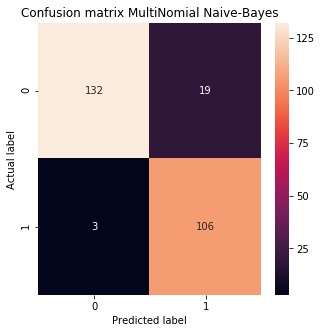

In [23]:
#Multi-Nomial Naive Bayes
plot_cm(output_unigram_testing,predicted_mnb, "MultiNomial Naive-Bayes")

Legitimate Transactions Detected (True Negatives):  117
Legitimate Transactions Incorrectly Detected (False Positives):  34
Fraudulent Transactions Missed (False Negatives):  35
Fraudulent Transactions Detected (True Positives):  74
Total Fraudulent Transactions:  109


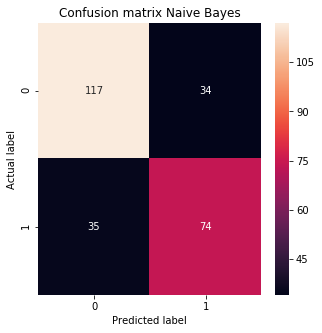

In [24]:
# Naive Bayes
plot_cm(output_unigram_testing, y_pred_NB, "Naive Bayes") 

Legitimate Transactions Detected (True Negatives):  142
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  99
Total Fraudulent Transactions:  109


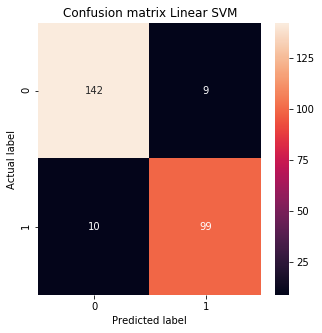

In [25]:
# Using SVM
plot_cm(output_unigram_testing, prediction_SVM, "Linear SVM") 

In [26]:
print(output_unigram_testing.size)

260


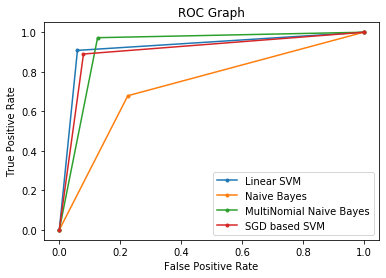

In [27]:

##Plotting ROC Graph
## Linear SVM and Multi-Nomial Naive Bayes model has similar good performance based on ROC graph

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

SVM_auc = roc_auc_score(output_unigram_testing, prediction_SVM)
NB_auc = roc_auc_score(output_unigram_testing, y_pred_NB)
MNB_auc = roc_auc_score(output_unigram_testing,predicted_mnb)
sgdSVM_auc = roc_auc_score(output_unigram_testing, sgdSVM_pred)

SVM_fpr, SVM_tpr, _ = roc_curve(output_unigram_testing, prediction_SVM)
NB_fpr, NB_tpr, _ = roc_curve(output_unigram_testing, y_pred_NB)
MNB_fpr, MNB_tpr,_  = roc_curve(output_unigram_testing,predicted_mnb)
sgdSVM_fpr, sgdSVM_tpr, _ = roc_curve(output_unigram_testing, sgdSVM_pred)

# plot the roc curve for the model
plt.plot(SVM_fpr, SVM_tpr, marker='.', label='Linear SVM')
plt.plot(NB_fpr, NB_tpr, marker='.', label='Naive Bayes')
plt.plot(MNB_fpr, MNB_tpr, marker='.', label='MultiNomial Naive Bayes')
plt.plot(sgdSVM_fpr, sgdSVM_tpr, marker='.', label='SGD based SVM')

plt.title('ROC Graph')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
 


In [28]:
# Print AUC Score for each model
##################################
# Linear SVM has the highest AUC performance score
###################################
print("Linear SVM AUC score: {}".format(SVM_auc))
print("Naive Bayes AUC score: {}".format(NB_auc))
print("MultiNomial Naive Bayes AUC : {}".format(MNB_auc))
print("SGD based SVM AUC : {}".format(sgdSVM_auc))

Linear SVM AUC score: 0.9243271158636613
Naive Bayes AUC score: 0.72686675982745
MultiNomial Naive Bayes AUC : 0.9233246248253235
SGD based SVM AUC : 0.9052190291026186
